In [1]:
from eiten import Eiten
import numpy as np
import json

In [2]:
class ArgsObj:
    history_to_use = None
    data_granularity_minutes = None
    is_test = None
    future_bars = None
    apply_noise_filtering = None
    only_long = None
    market_index = None
    eigen_portfolio_number = None
    stocks_file_path = None
    
    def __init__(self, history_to_use=90, data_granularity_minutes=3600, is_test=1, future_bars=30, 
    apply_noise_filtering=1, only_long=0, market_index='QQQ', eigen_portfolio_number=3, 
    stocks_file_path='stocks/stocks.txt') -> None:
        self.history_to_use = history_to_use
        self.data_granularity_minutes = data_granularity_minutes
        self.is_test = is_test
        self.future_bars = future_bars
        self.apply_noise_filtering = apply_noise_filtering
        self.only_long = only_long
        self.market_index = market_index
        self.eigen_portfolio_number = eigen_portfolio_number
        self.stocks_file_path = stocks_file_path
    
args = ArgsObj(
    history_to_use=90, data_granularity_minutes=3600, is_test=1, future_bars=30, 
    apply_noise_filtering=1, only_long=0, market_index='QQQ', eigen_portfolio_number=3, 
    stocks_file_path='stocks/stocks.txt'
)

In [3]:
eiten = Eiten(args)


--* Eiten has been initialized...

--> Data engine has been initialized...
Loading all stocks from file...
Total number of stocks: 11

--$ Simulator has been initialized

--= Strategy manager has been created...
Genetic algo strategy has been created
Minimum Variance strategy has been created
Eigen portfolio strategy has been created
Maximum sharpe ratio strategy has been created
Helper functions have been created

--# Backtester has been initialized




Loading data for all stocks...


 55%|█████▍    | 6/11 [00:01<00:00,  5.20it/s]


1 Failed download:
- FB: No data found, symbol may be delisted


100%|██████████| 11/11 [00:02<00:00,  4.63it/s]



** Applying random matrix theory to filter out noise in the covariance matrix...

-$ Calculating portfolio weights using eigen values...
-! Calculating portfolio weights using minimum variance portfolio algorithm...
-# Calculating portfolio weights using maximum sharpe portfolio algorithm...
-* Calculating portfolio weights using genetic algorithm...

*% Printing portfolio weights...

-------- Weights for Eigen Portfolio --------
Symbol: AAPL, Weight: -0.0833
Symbol: AMD, Weight: -0.2060
Symbol: AMZN, Weight: -0.1347
Symbol: EEM, Weight: -0.0419
Symbol: ETH-USD, Weight: 0.0046
Symbol: MSFT, Weight: -0.0780
Symbol: NFLX, Weight: -0.3938
Symbol: NVDA, Weight: -0.2903
Symbol: SQQQ, Weight: 0.2449
Symbol: TSLA, Weight: 1.9786

-------- Weights for Minimum Variance Portfolio (MVP) --------
Symbol: AAPL, Weight: 0.1081
Symbol: AMD, Weight: 0.0373
Symbol: AMZN, Weight: 0.0697
Symbol: EEM, Weight: 0.3094
Symbol: ETH-USD, Weight: 0.0093
Symbol: MSFT, Weight: 0.1633
Symbol: NFLX, Weight: 0.0238

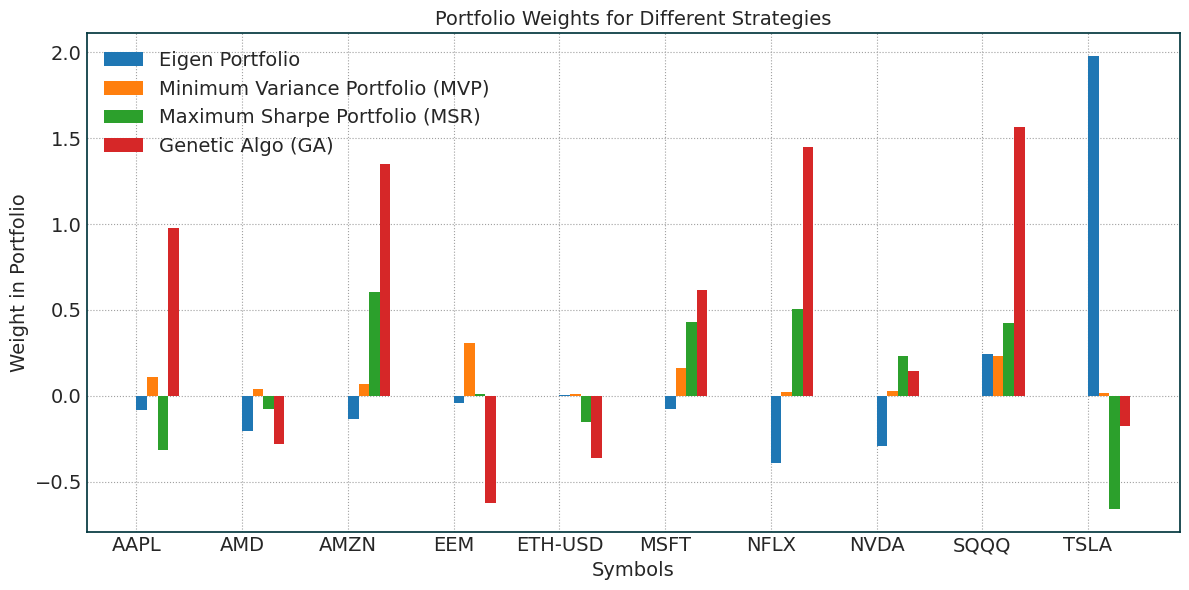


*& Backtesting the portfolios...


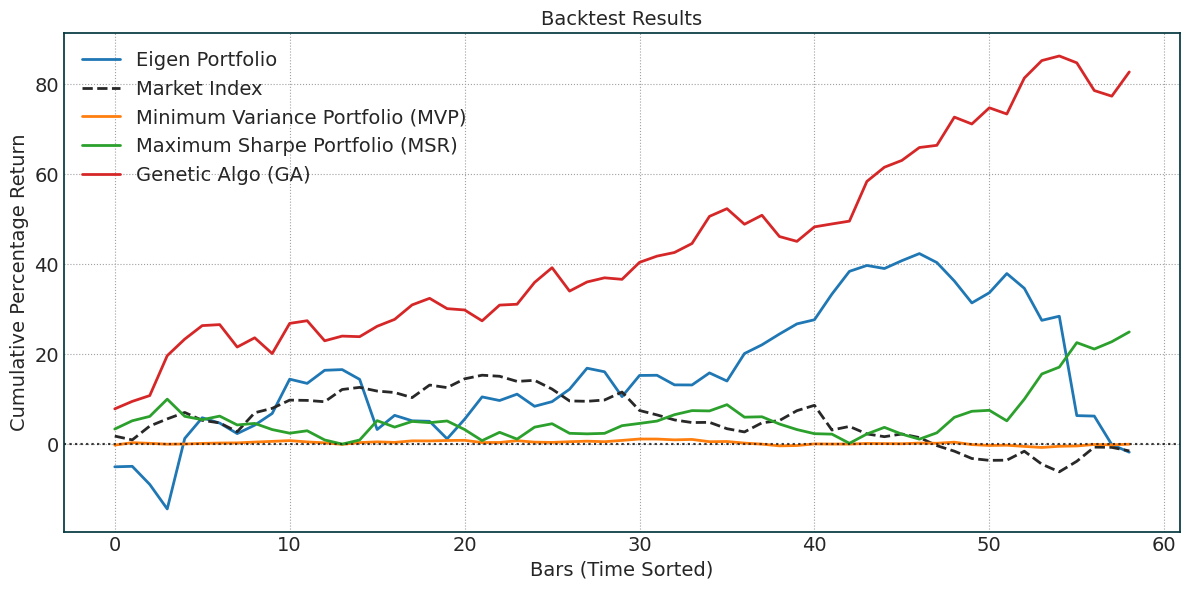


#^ Future testing the portfolios...


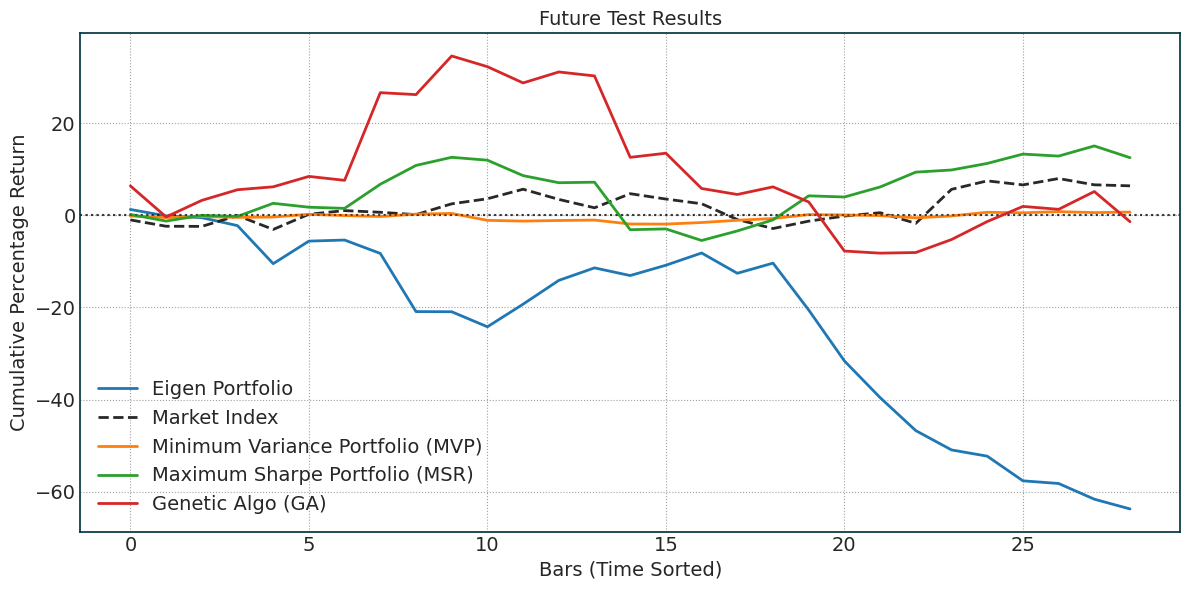


+$ Simulating future prices using monte carlo...


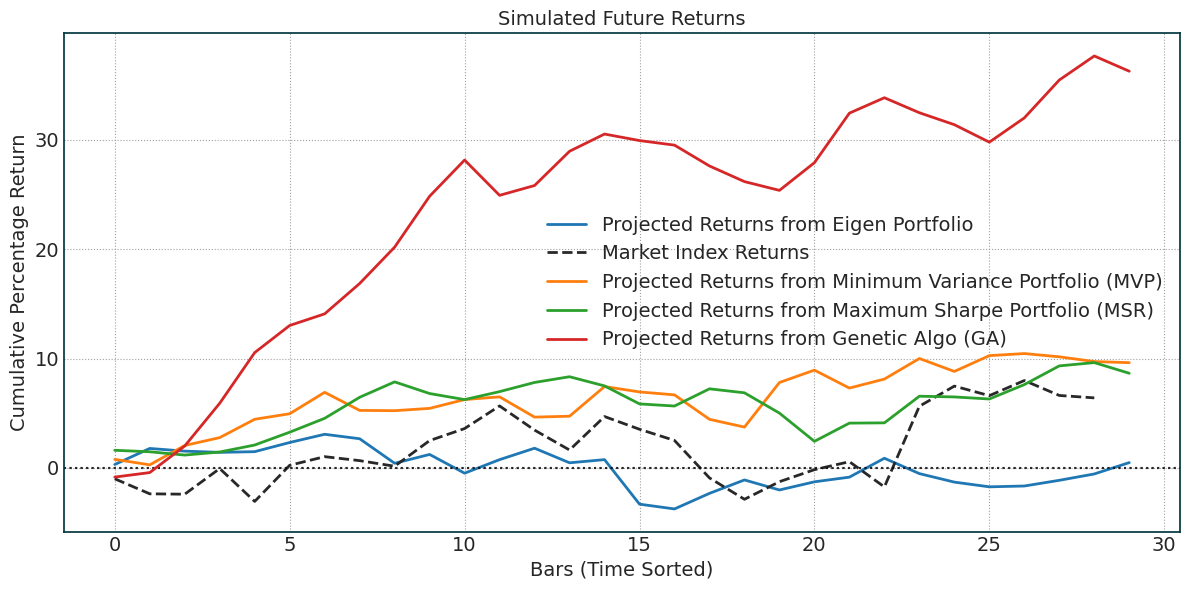

In [4]:
historical_price_info, future_prices, symbol_names, predicted_return_vectors, returns_matrix, returns_matrix_percentages = eiten.load_data()
historical_price_market, future_prices_market = eiten.dataEngine.get_market_index_price()

# Calculate covariance matrix
covariance_matrix = np.cov(returns_matrix)

# Use random matrix theory to filter out the noisy eigen values
if eiten.args.apply_noise_filtering:
    print(
        "\n** Applying random matrix theory to filter out noise in the covariance matrix...\n")
    covariance_matrix = eiten.strategyManager.random_matrix_theory_based_cov(
        returns_matrix)

# Get weights for the portfolio
eigen_portfolio_weights_dictionary = eiten.strategyManager.calculate_eigen_portfolio(
    symbol_names, covariance_matrix, eiten.args.eigen_portfolio_number)
mvp_portfolio_weights_dictionary = eiten.strategyManager.calculate_minimum_variance_portfolio(
    symbol_names, covariance_matrix)
msr_portfolio_weights_dictionary = eiten.strategyManager.calculate_maximum_sharpe_portfolio(
    symbol_names, covariance_matrix, predicted_return_vectors)
ga_portfolio_weights_dictionary = eiten.strategyManager.calculate_genetic_algo_portfolio(
    symbol_names, returns_matrix_percentages)

# Print weights
print("\n*% Printing portfolio weights...")
eiten.print_and_plot_portfolio_weights(
    eigen_portfolio_weights_dictionary, 'Eigen Portfolio', plot_num=1)
eiten.print_and_plot_portfolio_weights(
    mvp_portfolio_weights_dictionary, 'Minimum Variance Portfolio (MVP)', plot_num=2)
eiten.print_and_plot_portfolio_weights(
    msr_portfolio_weights_dictionary, 'Maximum Sharpe Portfolio (MSR)', plot_num=3)
eiten.print_and_plot_portfolio_weights(
    ga_portfolio_weights_dictionary, 'Genetic Algo (GA)', plot_num=4)
eiten.draw_plot("output/weights.png")

WEIGHTS = dict(
    eigen = eigen_portfolio_weights_dictionary,
    minvar = mvp_portfolio_weights_dictionary,
    sharpe = msr_portfolio_weights_dictionary,
    gen = ga_portfolio_weights_dictionary
)

# Back test
results = dict()
print("\n*& Backtesting the portfolios...")
results["backtest"] = dict()
results["backtest"]["eigen"] = eiten.backTester.back_test(symbol_names, eigen_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            historical_price_market,
                            eiten.args.only_long,
                            market_chart=True,
                            strategy_name='Eigen Portfolio')
results["backtest"]["minvar"] = eiten.backTester.back_test(symbol_names,
                            mvp_portfolio_weights_dictionary,
                            eiten.data_dictionary, historical_price_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Minimum Variance Portfolio (MVP)')
results["backtest"]["sharpe"] = eiten.backTester.back_test(symbol_names, msr_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            historical_price_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Maximum Sharpe Portfolio (MSR)')
results["backtest"]["gen"] = eiten.backTester.back_test(symbol_names,
                            ga_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            historical_price_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Genetic Algo (GA)')
eiten.draw_plot("output/backtest.png")

print("\n#^ Future testing the portfolios...")
# Future test
results["future"] = dict()
results["future"]["eigen"] = eiten.backTester.future_test(symbol_names,
                            eigen_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            future_prices_market,
                            eiten.args.only_long,
                            market_chart=True,
                            strategy_name='Eigen Portfolio')
results["future"]["minvar"] = eiten.backTester.future_test(symbol_names,
                            mvp_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            future_prices_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Minimum Variance Portfolio (MVP)')
results["future"]["sharpe"] = eiten.backTester.future_test(symbol_names,
                            msr_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            future_prices_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Maximum Sharpe Portfolio (MSR)')
results["future"]["gen"] = eiten.backTester.future_test(symbol_names,
                            ga_portfolio_weights_dictionary,
                            eiten.data_dictionary,
                            future_prices_market,
                            eiten.args.only_long,
                            market_chart=False,
                            strategy_name='Genetic Algo (GA)')
eiten.draw_plot("output/future_tests.png")

# Simulation
print("\n+$ Simulating future prices using monte carlo...")
results["sim"] = dict()
results["sim"]["eigen"] = eiten.simulator.simulate_portfolio(symbol_names,
                                    eigen_portfolio_weights_dictionary,
                                    eiten.data_dictionary,
                                    future_prices_market,
                                    eiten.args.is_test,
                                    market_chart=True,
                                    strategy_name='Eigen Portfolio')
results["sim"]["minvar"] = eiten.simulator.simulate_portfolio(symbol_names,
                                    eigen_portfolio_weights_dictionary,
                                    eiten.data_dictionary,
                                    future_prices_market,
                                    eiten.args.is_test,
                                    market_chart=False,
                                    strategy_name='Minimum Variance Portfolio (MVP)')
results["sim"]["sharpe"] = eiten.simulator.simulate_portfolio(symbol_names,
                                    eigen_portfolio_weights_dictionary,
                                    eiten.data_dictionary,
                                    future_prices_market,
                                    eiten.args.is_test,
                                    market_chart=False,
                                    strategy_name='Maximum Sharpe Portfolio (MSR)')
results["sim"]["gen"] = eiten.simulator.simulate_portfolio(symbol_names,
                                    ga_portfolio_weights_dictionary,
                                    eiten.data_dictionary,
                                    future_prices_market,
                                    eiten.args.is_test,
                                    market_chart=False,
                                    strategy_name='Genetic Algo (GA)')
eiten.draw_plot("output/monte_carlo.png")

In [5]:
# print(results)
# 
# print(results["sim"]["eigen"][-1],results["sim"]["sharpe"][-1])

0.480954969583006 8.650553774672208


In [6]:
## next interpret results
# with open('output/results.json', 'w') as fp:
#     json.dump(results, fp, indent=4)
from pprint import pprint

winners = dict()
for testtype in results.keys():
    highestWin = -99999
    best = None
    for strategy in results[testtype].keys():
        if results[testtype][strategy][-1] > highestWin:
            highestWin = results[testtype][strategy][-1]
            best = strategy
    winners[testtype] = dict(name = best, win = highestWin, weights = WEIGHTS[best])

with open('output/winners.json', 'w') as fp:
    json.dump(winners, fp, indent=4)
pprint(winners)

{'backtest': {'name': 'gen',
              'weights': {'AAPL': 0.9744098607488975,
                          'AMD': -0.2778378080385802,
                          'AMZN': 1.352282143959139,
                          'EEM': -0.6230116819878121,
                          'ETH-USD': -0.3638709120997227,
                          'MSFT': 0.6176506178829344,
                          'NFLX': 1.4497243803246722,
                          'NVDA': 0.14733142516831432,
                          'SQQQ': 1.5676090062256574,
                          'TSLA': -0.17738059882353843},
              'win': 82.73705384965294},
 'future': {'name': 'sharpe',
            'weights': {'AAPL': -0.31674048749189454,
                        'AMD': -0.07958492709050748,
                        'AMZN': 0.60630399812488,
                        'EEM': 0.011023893159859643,
                        'ETH-USD': -0.15070676570679295,
                        'MSFT': 0.4273651885031664,
                        'NFLX': 0.